In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

raw_df = pd.read_csv('./card_transdata.csv')

In [32]:
df = raw_df.copy()
df.drop_duplicates(inplace=True)
print("Duplicated values dropped succesfully")

Duplicated values dropped succesfully


In [33]:
labels=["Valid","Fraud"]

fraud_or_not = raw_df["fraud"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=raw_df['fraud'].value_counts(), names=labels , width=700, height=400, 
             color_discrete_sequence=["skyblue","black"]
             ,title="Fraud vs Valid transactions")
fig.show()

print('Valid:', round(raw_df['fraud'].value_counts()[0]/len(raw_df) * 100,2), '% of the dataset')
print('Frauds:', round(raw_df['fraud'].value_counts()[1]/len(raw_df) * 100,2), '% of the dataset')

Valid: 91.26 % of the dataset
Frauds: 8.74 % of the dataset


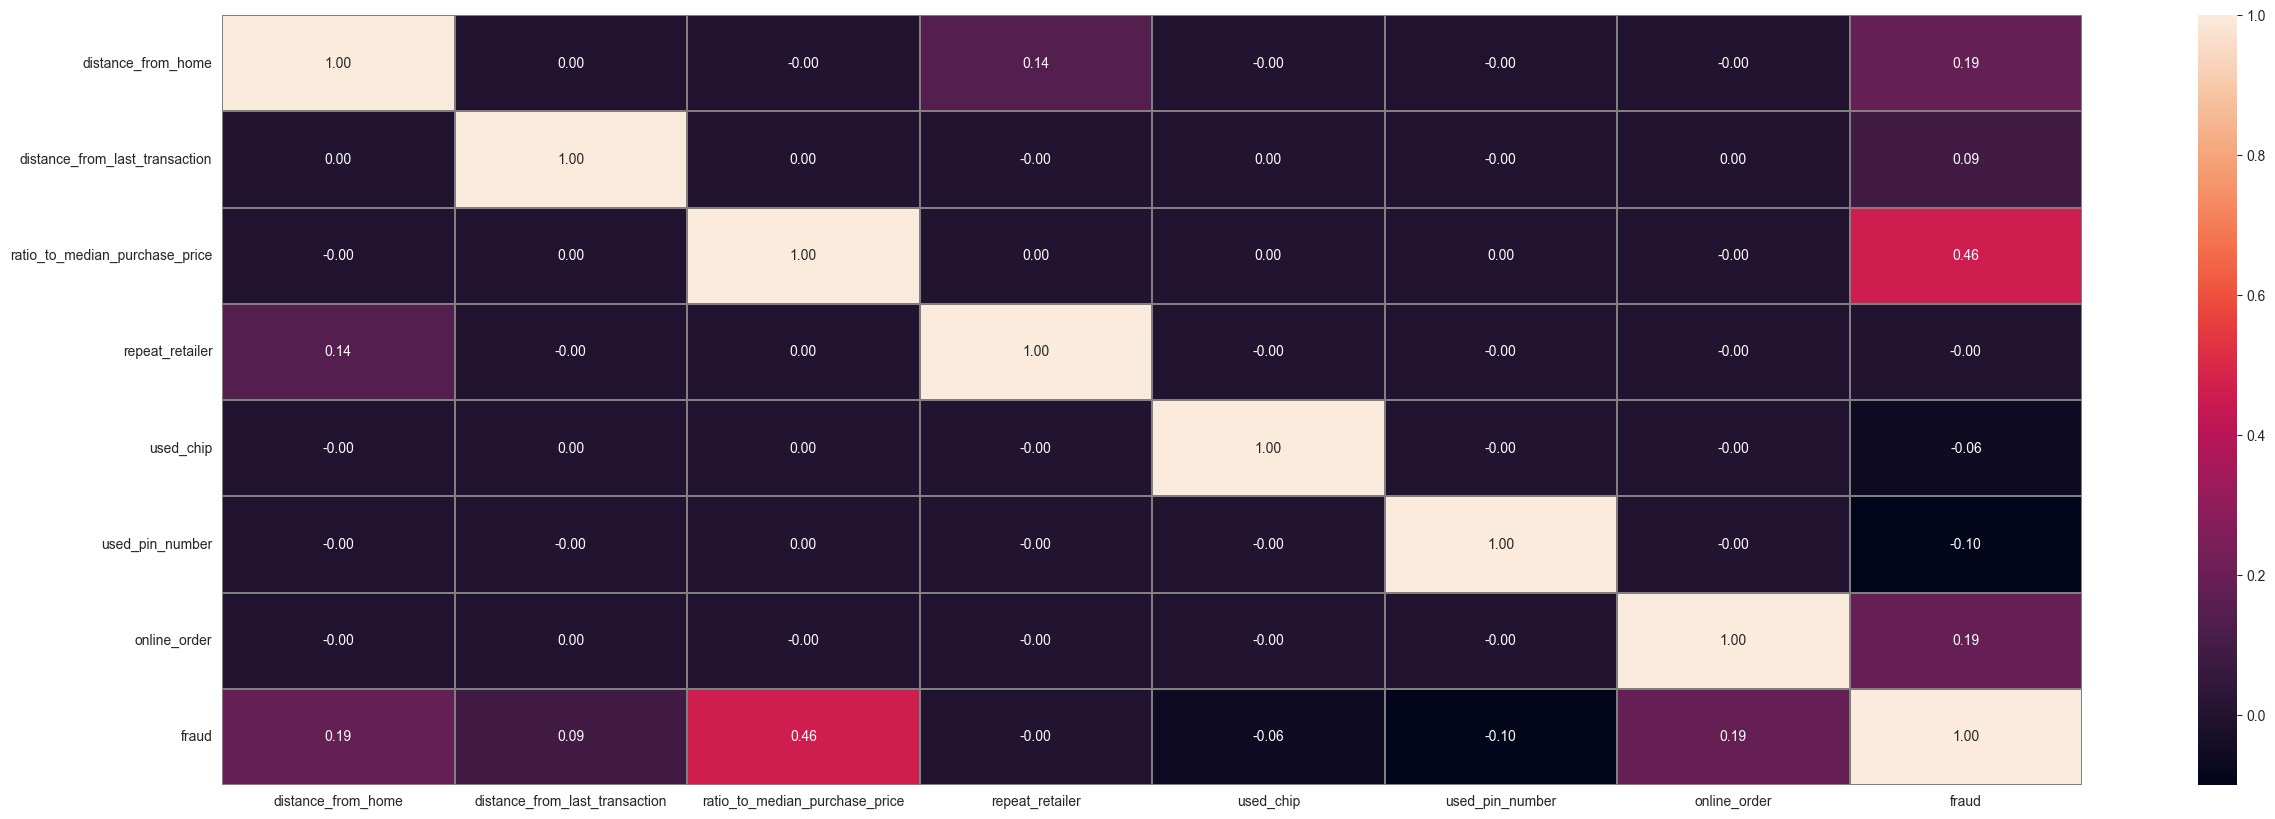

In [34]:
plt.figure(figsize = (30, 10))
sns.heatmap(
    df.corr(),
    annot = True,
    fmt = '.2f',
    linewidths=0.1,
    linecolor='gray',
)

plt.show()
# Table de corrélations à effectuer sur un plus grand échantillon de données

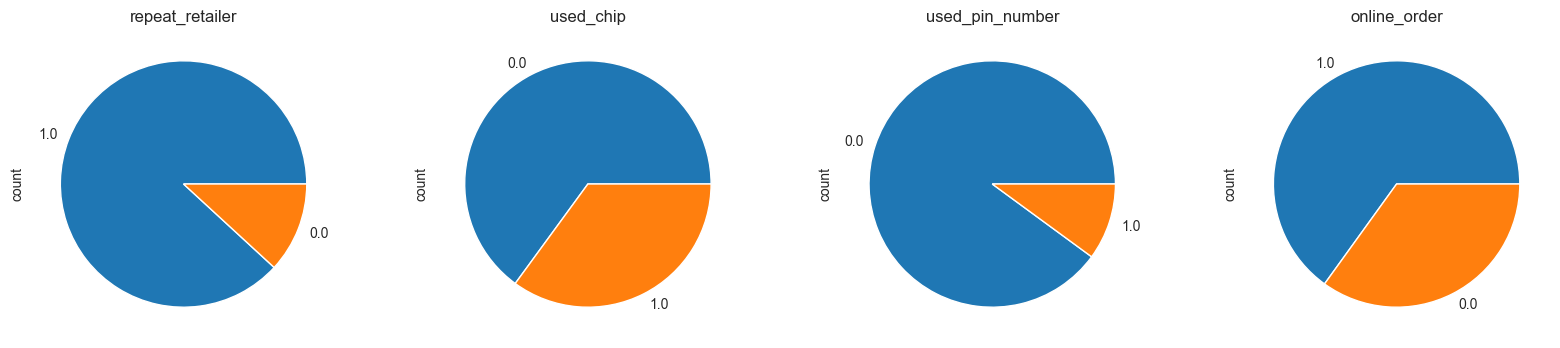

In [35]:
cat_features = ['repeat_retailer', 'used_chip','used_pin_number', 'online_order']
fig,ax = plt.subplots(1,4,figsize=(20,4))
for i,col in enumerate(cat_features):
    df[col].value_counts().plot(kind='pie',ax=ax[i],title=col)

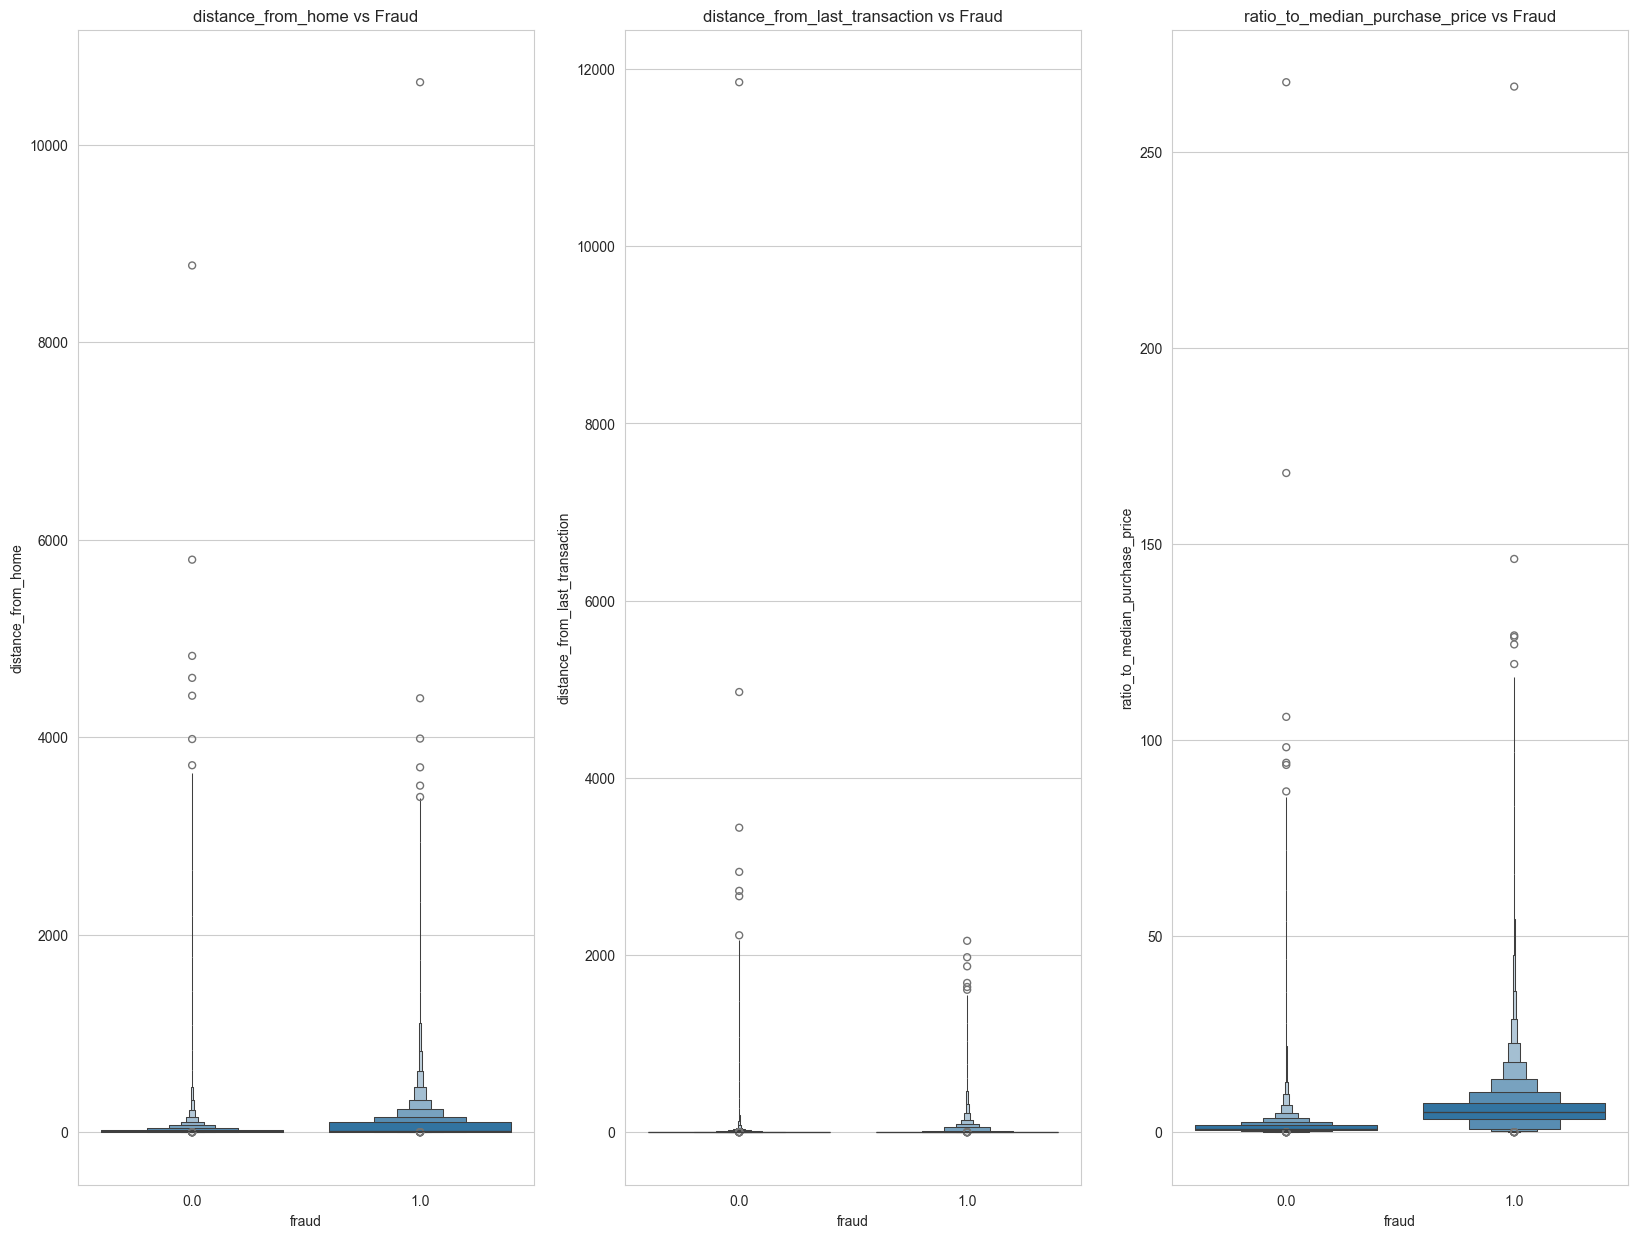

In [36]:
num_features = ['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price']
fig,ax = plt.subplots(1,3,figsize=(20,15))
for i,col in enumerate(num_features):
    sns.boxenplot(x=df['fraud'],y=df[col],ax=ax[i])
    ax[i].set_title(f'{col} vs Fraud')

Cross Validation Scores:  [0.99978547 0.99978547 0.99978547 0.99985699 0.99992849]
Scores Mean:  0.9998283783540554
Scores Standard Deviation:  5.7211050409744465e-05


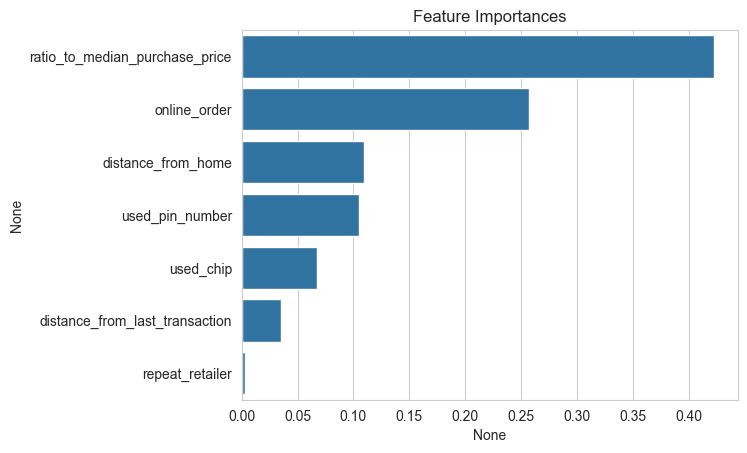

In [43]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

def validate(model,X_train,y_train,score,n):
    
    '''this function is to validate the model across multiple stratified splits'''
    
    splits = StratifiedKFold(n_splits=n)
    validate = cross_val_score(model,X_train,y_train,scoring=score,cv=splits)
    print('Cross Validation Scores: ',validate)
    print('Scores Mean: ',validate.mean())
    print('Scores Standard Deviation: ',validate.std())
    model.fit(X_train,y_train)
    return model

features = df.columns.drop(['fraud'])
target = 'fraud'

X = df[features]
y = df[target]
X_train , X_test ,y_train , y_test = train_test_split(X,y,test_size = 0.2 ,random_state = 42 ,stratify=y)

dec_tree = validate(DecisionTreeClassifier(random_state=42),X_train,y_train,'recall',5)
feat_imp_dt = pd.Series(dec_tree.feature_importances_,index=X.columns).sort_values(ascending=False)
sns.barplot(x=feat_imp_dt,y=feat_imp_dt.index)
plt.title('Feature Importances');

In [38]:
from imblearn.under_sampling import RandomUnderSampler

X = df.drop('fraud', axis=1)
y = df['fraud']

# Perform random undersampling
undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Create a DataFrame with the resampled data
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df['fraud'] = y_resampled

print("Class Distribution after Undersampling:")
print(resampled_df['fraud'].value_counts(normalize=True))

Class Distribution after Undersampling:
fraud
0.0    0.666667
1.0    0.333333
Name: proportion, dtype: float64


In [39]:
import pickle
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

selected_features = ['distance_from_home', 'ratio_to_median_purchase_price', 'online_order']
X = resampled_df[selected_features]
y = resampled_df['fraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save the trained Logistic Regression model to a file
with open("random_forest_model.pkl", "wb") as model_file:
    pickle.dump(rf_model, model_file)

Accuracy: 0.9610236070325312

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97     34956
         1.0       0.95      0.93      0.94     17486

    accuracy                           0.96     52442
   macro avg       0.96      0.95      0.96     52442
weighted avg       0.96      0.96      0.96     52442


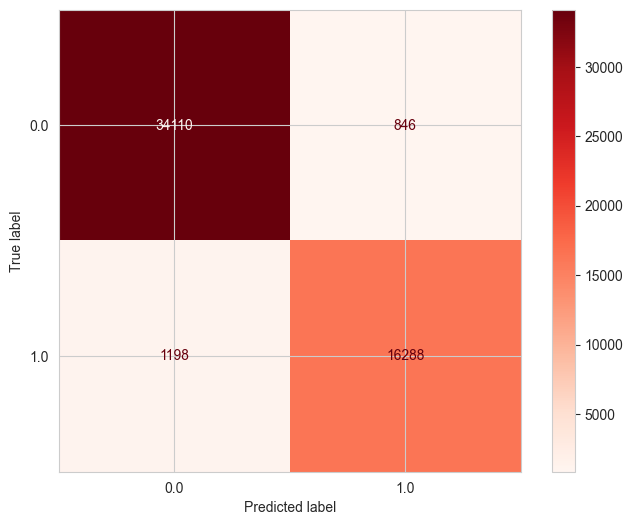

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(8, 6))
                                
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax,
                                        cmap='Reds', colorbar=True)

plt.show()

In [41]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()

# Hyperparameter Optimization
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt', 'auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5], 
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 5]
             }

# Run the grid search
grid_obj = GridSearchCV(rf, parameters)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the rf to the best combination of parameters
rf = grid_obj.best_estimator_

# Train the model using the training sets 
rf.fit(X_train,y_train)

C:\Users\schmi\PycharmProjects\FraudDetectionIA\venv\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


360 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\schmi\PycharmProjects\FraudDetectionIA\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\schmi\PycharmProjects\FraudDetectionIA\venv\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\schmi\PycharmProjects\FraudDetectionIA\venv\Lib\site-packages\sklearn\base.py", 

RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=9)

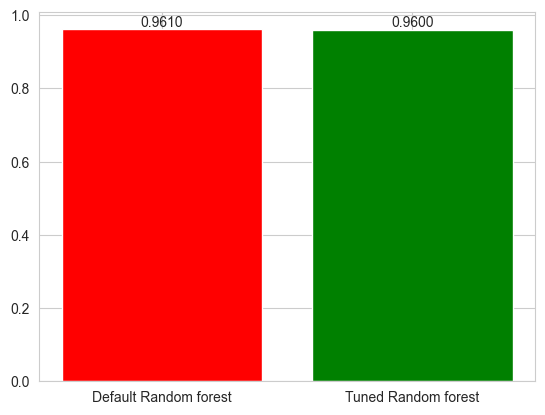

In [42]:
y_pred = rf.predict(X_test)
acc_rf = round( metrics.accuracy_score(y_test, y_pred), 2 )
figure, axes = plt.subplots()

plt.bar(
    x = ["Default Random forest", "Tuned Random forest"],
    height = [rf_model.score(X_test, y_test),
              acc_rf],
    color = ["red", "green"],
)
for bar in axes.patches:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.0,
        height,
        '%.4f' % height,
        ha='center',
        va='bottom',
    )
plt.show()